## EDA for Credit Card Fraud Detection System (FDS)
##### Gavin Qu, version 11.14.2025

#### Content: 
- The dataset contains transactions made by credit cards in September 2013 by European cardholders.
- This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. 

- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

- Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification. 

- *PCA*: The idea is to project the data onto a new set of orthogonal axes, called PCs ordered so that the first PC accounts for the largest variance in the data, the second PC account for the largest remaining variance orthogonal to the first, and so on. By keeping only the first few PCs (which captures most variance), you can simplify the data and reduce noise without losing the essential relationships between data. 
- The eigenvectors of the covariance matrix is the principle components
- The eigenvector with the highest eigenvalue is the first PC, the second largest is PC2. 
- When you discard the principle components that explain the least variance (p - k components), you are also discarding the directions that contain the most "noise". 

In [2]:
#import kagglehub

# Download latest version
# path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

#print("Path to dataset files:", path)

## 1. Objective and Constraints
#### 1.1 Loss of Interpretability and Gain in Dimensionality Reduction
- Since PCA creates new axes that are linear combination of the original features, the column headers V1, V2, etc. no longer directly correspond to interpretable real world entities (like age, ZIP code...)
- Given the loss of correlation to original features, the coefficients used are unknown, which limits our ability to perform direct, causal analysis based on feature names alone. 
- Since PCs are orthogonal and uncorrelated to each other, this is actually beneficial for my usage of logistics regression, as it eliminates the issue of multicollinearity. 
- Features created this way should be ranked by amount of the variance they capture, V1 captures the most information (variance) in the original dataset and V28 captures the least information. This gives us the possibility of further dimensionality reduction if we are to drop the last features. 
- Since the original dataset has to be scaled/normalized before the PCA, and the PCs are derived from the covariance matrix, the original features scales are mixed together in the PCs. As a result, I don't have to worry about the scale of the features relative to each other from V1-V28. 

#### 1.2 Objective Formulation
I aim to understand how much predictive structure exists, how it manifests, and which modeling strategies given the PCA-obscured feature, can reliably extract that structure. Given the class imbalance, the key metric to measure performance should be Area under the Precision-Recall Curve (AUPRC). 

1. Do "Time", "Amount" and "Class" show clustering based on other features? This could introduce leakage. 
    - Think in terms of temporal leakage: do we have look-ahead bias? What if the fraud bursts occur in short windows. 
2. How do features V1-V28 behave distributionally across our predicted variable Class? 
    - Fraud vs. non-fraud could have subtle shift in means and variance. 
3. Time-series considerations. 
    - temporal split for validation, leave most recent time data as test set. 
4. What should I do with class imbalance ratio? Do I need to interpret results differently from other types of datasets? e.g. summary statistics
    - class imbalance affect some measurements such as accuracy. 
5. How do we interpret the V1-V28 Principle Components if we find feature importance? 
    - Feature importance would tell me which direction in PCA space separate fraud from not-fraud, not what original features do. (Which latent axes hold discriminative information?)
6. Most importantly, where does the model learn to separate signal from noise? 

## 2. Exploration with Plots and Summary Stats
#### 2.1 Compare Target Variable for Time, Amount
- Also look at a handful of PCA components
- Kernel densities to estimate the PDF 
- Look for difference in spread and tail on top of means. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/Users/gavinqu/dev/cc-fraud-detection/data/creditcard.csv')

# Display basic information about the dataset
print(data.info())
print(data.describe().T)  # transpose for better readability

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

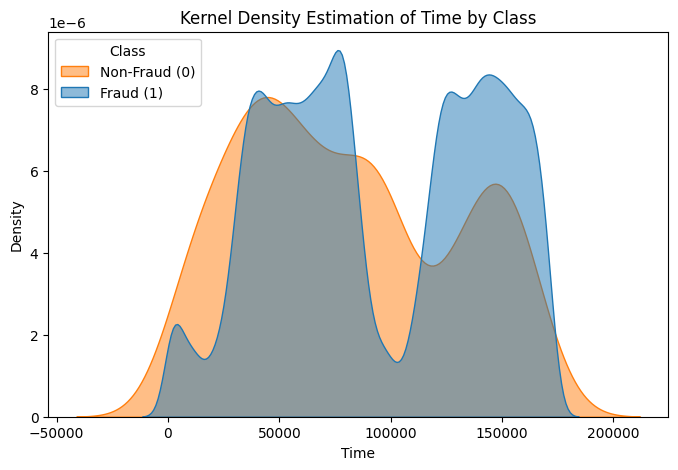

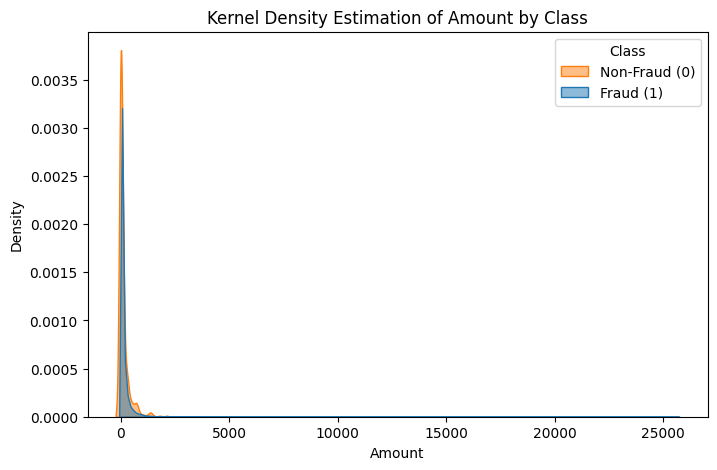

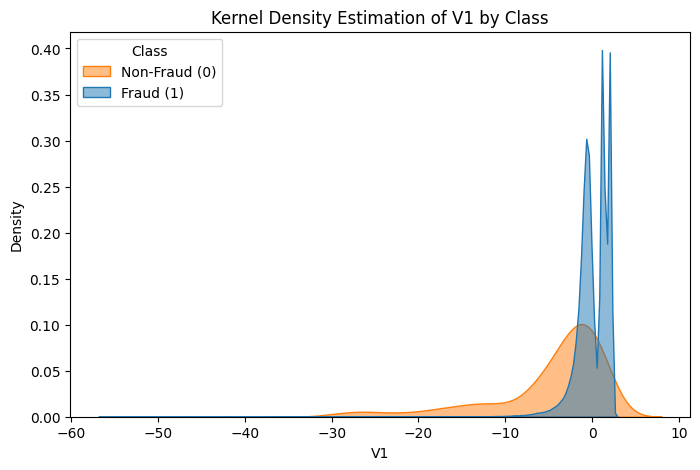

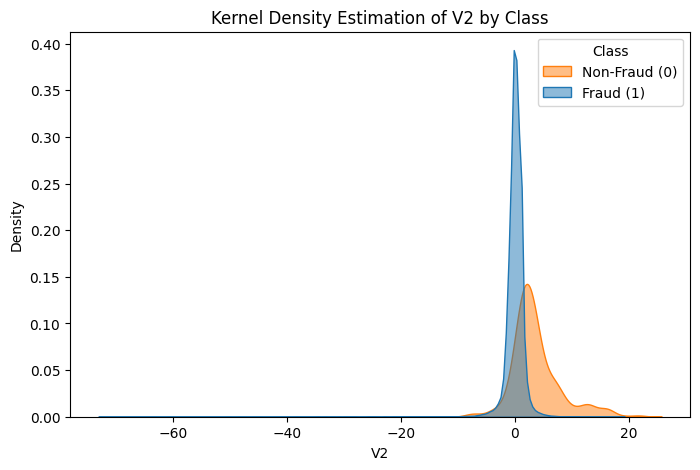

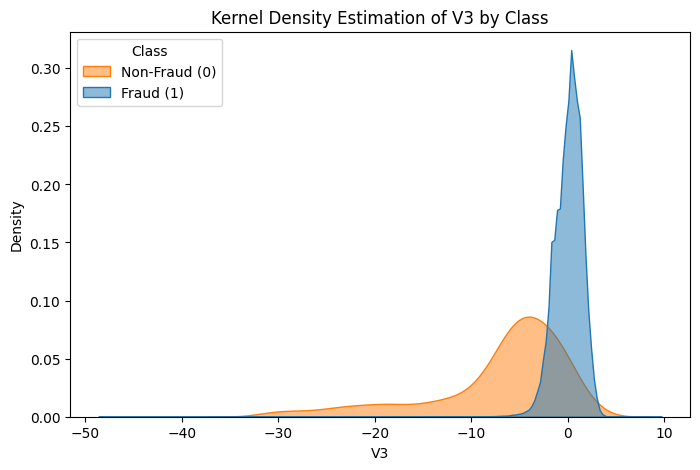

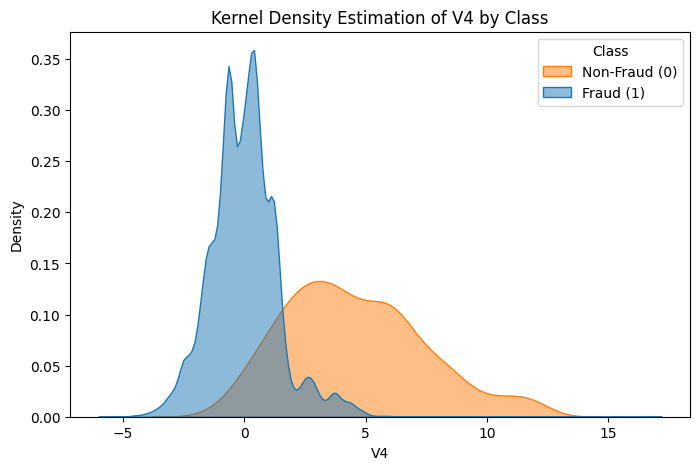

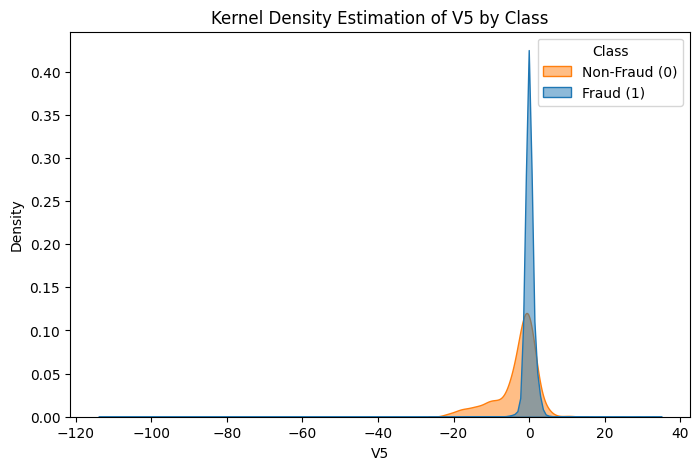

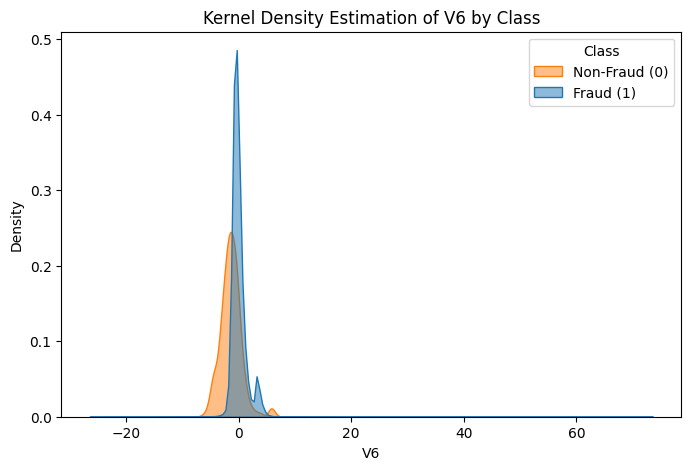

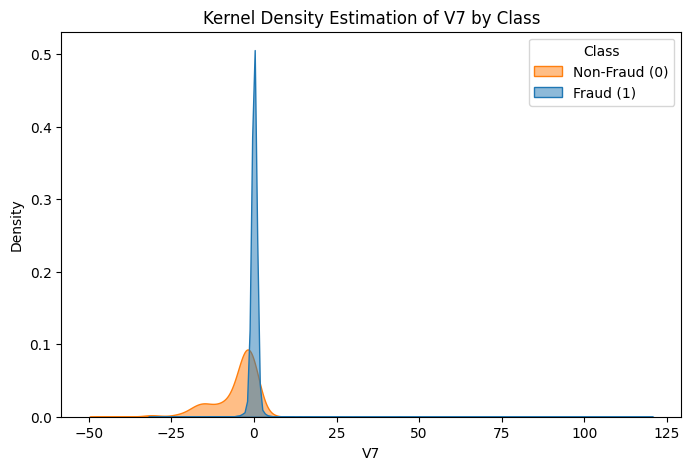

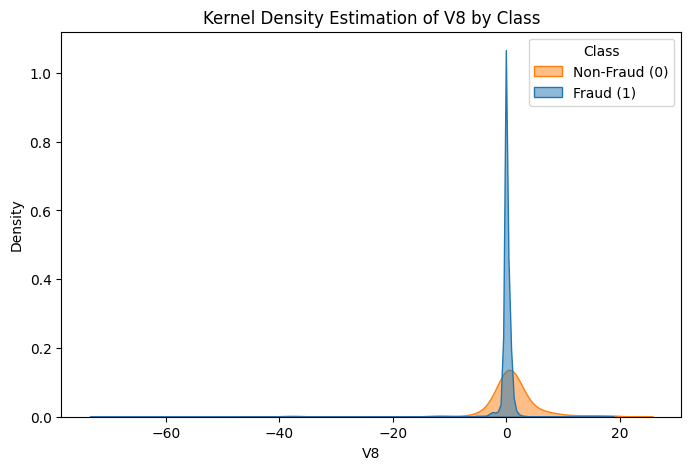

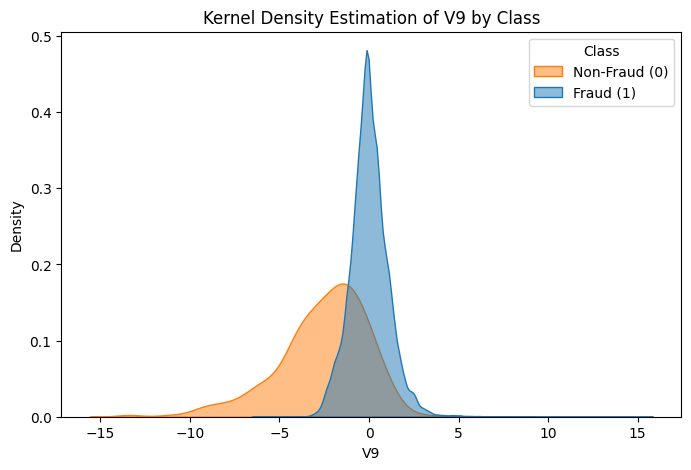

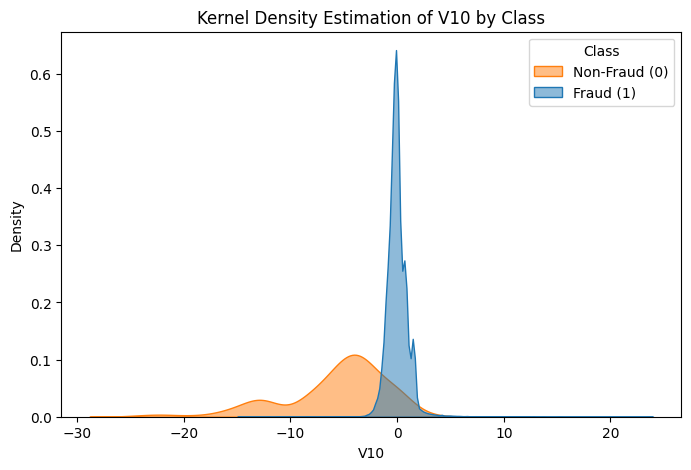

In [17]:
# Kernel Density Estimation Plots for 'Time' and 'Amount' by 'Class'
features_to_plot = ['Time', 'Amount', 'V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10']
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=data, x=feature, hue='Class', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'Kernel Density Estimation of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(title='Class', labels=['Non-Fraud (0)', 'Fraud (1)'])
    plt.show()

Notice the dip in the middle of the first kernel density plot involving time, probably a good idea to split the validation set near the minima. Worth noting that, in real datasets, fraud patterns look different for day/night, weekday/weekend timestamps.
#### 2.2 Pairwise Structure Modeling
- Plot 2D scatterplots for a few V_i vs V_j pairs, colored by class, hunting for regions where fraud density is locally higher
- Compute simple correlation across all data, then within each class separately
    - Unexpected deviations hint at interaction effects that tree-based models can pick up well. 

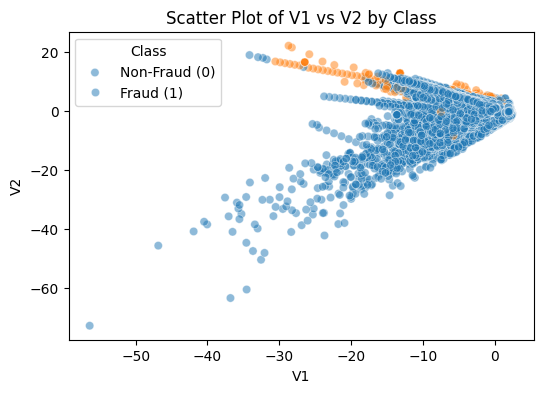

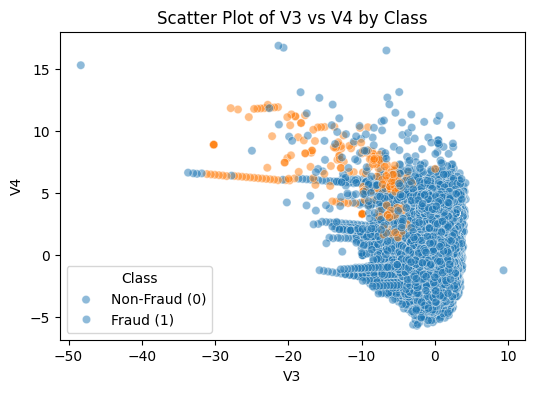

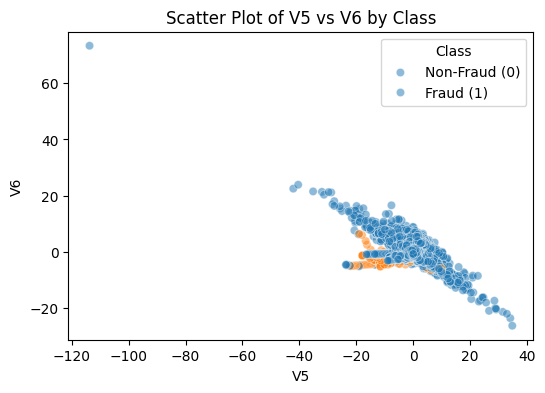

In [5]:
# 2D Scatter Plots for Selected PCA Components
pca_pairs = [('V1', 'V2'), ('V3', 'V4'), ('V5', 'V6')]
for x_feature, y_feature in pca_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=data, x=x_feature, y=y_feature, hue='Class', alpha=0.5)
    plt.title(f'Scatter Plot of {x_feature} vs {y_feature} by Class')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.legend(title='Class', labels=['Non-Fraud (0)', 'Fraud (1)'])
    plt.show()

It's worth noting that all three pairs have similar regions of density among fraud and non-frauds. 

In [ ]:
# Compute correlation across all data
correlation_matrix = data.corr()
print("Overall Correlation Matrix:")
print(correlation_matrix)

# Compute correlation within each class separately
for cls in data['Class'].unique():
    class_data = data[data['Class'] == cls]
    class_correlation_matrix = class_data.corr()
    print(f"Correlation Matrix for Class {cls}:")
    print(class_correlation_matrix)

Difficult to interpret a 30 x 30 matrice and 435 pairs of correlations, luckily the PCA tells us that the useful features are ranked higher. 
#### 2.3 Temporal Structure
- Already observed the multimodal behavior of the time component
- Does time encode a signal when building train / validation split

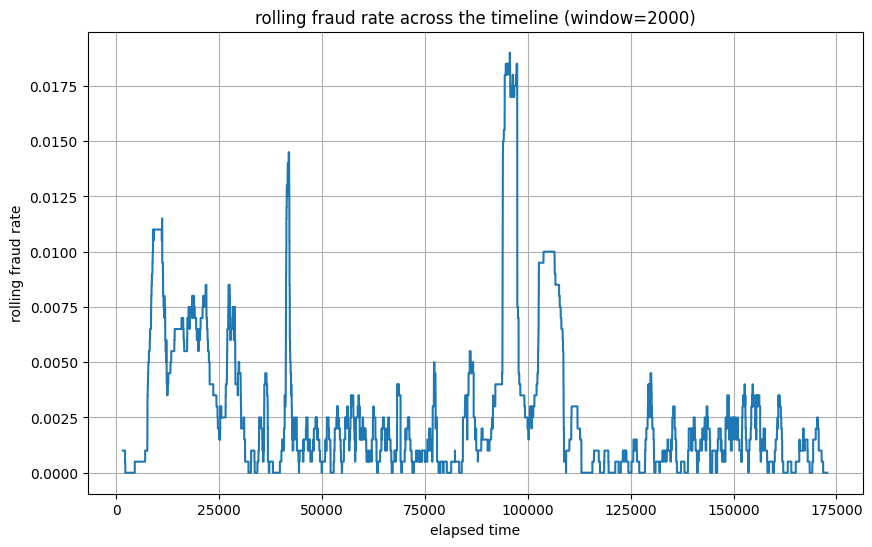

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = data.sort_values('Time')

window = 2000
df_sorted['rolling_fraud_rate'] = (
    df_sorted['Class'].rolling(window=window).mean()
)

plt.figure(figsize=(10,6))
plt.plot(df_sorted['Time'], df_sorted['rolling_fraud_rate'])
plt.title(f"rolling fraud rate across the timeline (window={window})")
plt.xlabel("elapsed time")
plt.ylabel("rolling fraud rate")
plt.grid(True)
plt.show()

In [9]:
# compre first half and second half
median_time = data['Time'].median()
data['half'] = (data['Time'] > median_time).astype(int)
fraud_rate_half = data.groupby('half')['Class'].mean()
print(fraud_rate_half)

half
0    0.001889
1    0.001566
Name: Class, dtype: float64


There are some spikes and clustering visible in the rolling average, but there is negligible time-related drift in comparison between first and second half. Meaning I should can still do random train/validation split, but be cautious of it later on. 

#### 2.4 Class Structure and Imbalance Dynamics

In [16]:
# test for imbalance in data especially for Class as ratio
class_counts = data['Class'].value_counts()
class_ratios = class_counts / len(data)
print(f"Class Counts:\n{class_counts}")
print(f"\nClass Ratios:\n{class_ratios}")

Class Counts:
Class
0    284315
1       492
Name: count, dtype: int64

Class Ratios:
Class
0    0.998273
1    0.001727
Name: count, dtype: float64


#### 2.5 Interpretation of PCA features
- PCAs are bascially directions in a transformed space
- Contains variance, it's a way of taking high dimensioinal points and rotating it to find the directions where the data varies the most. Thsoe directions become the new features.
- don't know what each PCA axis represent semantically, but I do know whetehr certain directions make fraud look different. 
- *“Interpretability is the degree to which a human can understand the cause of a decision.”*

#### 2.6 Preliminary Hypothesis on Signal-Noise Separation

## 3. Model Building
- SMOTE for imbalance